In [875]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 30 19:31:07 2014
@author: francesco
"""
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
#from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
import operator
import Quandl
from sklearn.metrics import roc_auc_score
import pandas.io.data
from sklearn.qda import QDA
import datetime
from IPython.display import display, HTML

In [153]:
#Methods
def loadDatasets(path_directory): 
    """
    import into dataframe all datasets saved in path_directory
    """
    #name = path_directory + '/procter.csv'
    #out = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/sp.csv'
    sp = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/nasdaq.csv'
    nasdaq = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/djia.csv'
    djia = pd.read_csv(name, index_col=0, parse_dates=True)
    
    #name = path_directory + '/treasury.csv'
    #treasury = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/hkong.csv'
    hkong = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/frankfurt.csv'
    frankfurt = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/paris.csv'
    paris = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/nikkei.csv'
    nikkei = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/london.csv'
    london = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/australia.csv'
    australia = pd.read_csv(name, index_col=0, parse_dates=True)
    
    #return [sp, nasdaq, djia, treasury, hkong, frankfurt, paris, nikkei, london, australia]
    #return [out, nasdaq, djia, frankfurt, hkong, nikkei, australia]
    return [out, nasdaq, djia, frankfurt, london, paris, hkong, nikkei, australia]
    

def count_missing(dataframe):
    """
    count number of NaN in dataframe
    """
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()

    
def addFeatures(dataframe, adjclose, returns, n):
    """
    operates on two columns of dataframe:
    - n >= 2
    - given Return_* computes the return of day i respect to day i-n. 
    - given AdjClose_* computes its moving average on n days
    """
    
    return_n = adjclose[9:] + "Time" + str(n)
    dataframe[return_n] = dataframe[adjclose].pct_change(n)
    
    roll_n = returns[7:] + "RolMean" + str(n)
    dataframe[roll_n] = pd.rolling_mean(dataframe[returns], n)
    
def mergeDataframes(datasets, index, target):
    """
    merges datasets in the list 
    """
    subset = []
    subset = [dataset.iloc[:, index:] for dataset in datasets[1:]]
    
    if target == 'CLASSIFICATION':    
        return datasets[0].iloc[:, index:].join(subset, how = 'outer')
    #elif target == 'REGRESSION':
    #    return datasets[0].iloc[:, index:].join(subset, how = 'outer')          
        
# def mergeDataframes(datasets, index, cut):
#     """
#     merges datasets in the list 
#     """
#     subset = []
#     subset = [dataset.iloc[:, index:] for dataset in datasets[1:]]
    
#     first = subset[0].merge(subset[1:], how = 'outer')
#     finance = datasets[0].iloc[:, index:].merge(first, how = 'left') 
#     finance = finance[finance.index > cut]
#     return finance

def applyTimeLag(dataset, lags, delta, back, target):
    """
    apply time lag to return columns selected according  to delta.
    Days to lag are contained in the lads list passed as argument.
    Returns a NaN free dataset obtained cutting the lagged dataset
    at head and tail
    """
    
    if target == 'CLASSIFICATION':
        maxLag = max(lags)

        columns = dataset.columns[::(2*max(delta)-1)]
        for column in columns:
            for lag in lags:
                newcolumn = column + str(lag)
                dataset[newcolumn] = dataset[column].shift(lag)

        return dataset.iloc[maxLag:-1,:]
#    elif target == 'REGRESSION':
#        maxLag = max(lags)
#        
#        columns = dataset.columns[::(2*max(delta)-1)]
#        for column in columns:
#            for lag in lags:
#                newcolumn = column + str(lag)
#                dataset[newcolumn] = dataset[column].shift(lag)
#
#        return dataset.iloc[maxLag:-1,:]       


def performCV(X_train, y_train, folds, method, parameters):
    """
    given complete dataframe, number of folds, the % split to generate 
    train and test set and features to perform prediction --> splits
    dataframein test and train set. Takes train set and splits in k folds.
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    returns mean of test accuracies
    """
    print ''
    print 'Parameters --------------------------------> ', parameters
    print 'Size train set: ', X_train.shape
    k = int(np.floor(float(X_train.shape[0])/folds))
    print 'Size of each fold: ', k
    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        print ''
        split = float(i-1)/i
        print 'Splitting the first ' + str(i) + ' chuncks at ' + str(i-1) + '/' + str(i) 
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        print 'Size of train+test: ', data.shape
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]        
        y_tr = output[:index]
        
        X_te = data[(index+1):]
        y_te = output[(index+1):]        
        
        acc[i-2] = performClassification(X_tr, y_tr, X_te, y_te, method, parameters)
        print 'Accuracy on fold ' + str(i) + ': ', acc[i-2]
    return acc.mean()   

def performTimeSeriesSearchGrid(X_train, y_train, folds, method, grid):
    """
    parameters is a dictionary with: keys --> parameter , values --> list of values of parameter
    """
    print ''
    print 'Performing Search Grid CV...'
    print 'Algorithm: ', method
    param = grid.keys()
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = performCV(dataset, folds, split, features, method, parameters)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)  
        print ''
        print 'Final CV Results: ', final        
        return final[0]
        
    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = performCV(dataset, folds, split, features, method, parameters)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)
        print ''
        print 'Final CV Results: ', final
        return final[0]


##################
################## MERGING SENTIMENT

def mergeSentimenToStocks(stocks):
    df = pd.read_csv('/home/francesco/BigData/Project/CSV/sentiment.csv', index_col = 'date')
    final = stocks.join(df, how='left')
    return final
       
        
###############################################################################    
###############################################################################    
###############################################################################
######## CLASSIFICATION    
    
#####IDEAS --> MULTIPLYEACH RETURN BY 100, QDA, AUC
#####    
    
def prepareDataForClassification(dataset, start_test):
    """
    generates categorical to be predicted column, attach to dataframe 
    and label the categories
    """
    le = preprocessing.LabelEncoder()
    
    dataset['UpDown'] = dataset['Return_Out']
    dataset.UpDown[dataset.UpDown >= 0] = 'Up'
    dataset.UpDown[dataset.UpDown < 0] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)
    
    features = dataset.columns[1:-1]
    X = dataset[features]    
    y = dataset.UpDown    
    
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    
    return X_train, y_train, X_test, y_test    

def prepareDataForModelSelection(X_train, y_train, start_validation):
    """
    gets train set and generates a validation set splitting the train.
    The validation set is mandatory for feature and model selection.
    """
    X = X_train[X_train.index < start_validation]
    y = y_train[y_train.index < start_validation]    
    
    X_val = X_train[X_train.index >= start_validation]    
    y_val = y_train[y_train.index >= start_validation]   
    
    return X, y, X_val, y_val
    
  
def performClassification(X_train, y_train, X_test, y_test, method, parameters):
    """
    performs classification on returns using serveral algorithms
    """
    #print ''
    print 'Performing ' + method + ' Classification...'    
    print 'Size of train set: ', X_train.shape
    print 'Size of test set: ', X_test.shape
   
    if method == 'RF':   
        return performRFClass(X_train, y_train, X_test, y_test)
        
    elif method == 'KNN':
        return performKNNClass(X_train, y_train, X_test, y_test)
    
    elif method == 'SVM':   
        return performSVMClass(X_train, y_train, X_test, y_test)
    
    elif method == 'ADA':
        return performAdaBoostClass(X_train, y_train, X_test, y_test, parameters)
    
    elif method == 'GTB': 
        return performGTBClass(X_train, y_train, X_test, y_test)

    elif method == 'QDA': 
        return performQDAClass(X_train, y_train, X_test, y_test)
    
def performRFClass(X_train, y_train, X_test, y_test):
    """
    Random Forest Binary Classification
    """
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
        
def performKNNClass(X_train, y_train, X_test, y_test):
    """
    KNN binary Classification
    """
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy

def performSVMClass(X_train, y_train, X_test, y_test):
    """
    SVM binary Classification
    """
    clf = SVC()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
    
def performAdaBoostClass(X_train, y_train, X_test, y_test, parameters):
    """
    Ada Boosting binary Classification
    """
    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators = n, learning_rate = l)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
    
def performGTBClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    clf = GradientBoostingClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy

def performQDAClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    clf = QDA()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy


##############################################################################
##############################################################################
##############################################################################   
##############################################################################
####### REGRESSION
    
def performRegression(dataset, split):
    """
    performs regression on returns using serveral algorithms
    """

    features = dataset.columns[1:]
    index = int(np.floor(dataset.shape[0]*split))
    train, test = dataset[:index], dataset[index:]
    print 'Size of train set: ', train.shape
    print 'Size of test set: ', test.shape
    
    output = 'Return_SP500'

    #print 'Accuracy RFC: ', performRFReg(train, test, features, output)
   
    #print 'Accuracy SVM: ', performSVMReg(train, test, features, output)
   
    #print 'Accuracy BAG: ', performBaggingReg(train, test, features, output)
   
    #print 'Accuracy ADA: ', performAdaBoostReg(train, test, features, output)
   
    #print 'Accuracy BOO: ', performGradBoostReg(train, test, features, output)

    print 'Accuracy KNN: ', performKNNReg(train, test, features, output)


def performRFReg(train, test, features, output):
    """
    Random Forest Regression
    """

    forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    forest = forest.fit(train[features], train[output])
    Predicted = forest.predict(test[features])
    

    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()        
    
    return mean_squared_error(test[output], Predicted), r2_score(test[output], Predicted)

def performSVMReg(train, test, features, output):
    """
    SVM Regression
    """

    clf = SVR()
    clf.fit(train[features], train[output])
    Predicted = clf.predict(test[features])
    
    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()        
    
    return mean_squared_error(test[output],Predicted), r2_score(test[output], Predicted)
    
def performBaggingReg(train, test, features, output):
    """
    Bagging Regression
    """
  
    clf = BaggingRegressor()
    clf.fit(train[features], train[output])
    Predicted = clf.predict(test[features])
    
    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()        
    
    return mean_squared_error(test[output],Predicted), r2_score(test[output], Predicted)  

def performAdaBoostReg(train, test, features, output):
    """
    Ada Boost Regression
    """

    clf = AdaBoostRegressor()
    clf.fit(train[features], train[output])
    Predicted = clf.predict(test[features])
    
    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()        
    
    return mean_squared_error(test[output],Predicted), r2_score(test[output], Predicted)

def performGradBoostReg(train, test, features, output):
    """
    Gradient Boosting Regression
    """
    
    clf = GradientBoostingRegressor()
    clf.fit(test[features], train[output])
    Predicted = clf.predict(test[features])
    
    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()    
    
    return mean_squared_error(test[output],Predicted), r2_score(test[output], Predicted)

def performKNNReg(train, test, features, output):
    """
    KNN Regression
    """

    clf = KNeighborsRegressor()
    clf.fit(train[features], train[output])
    Predicted = clf.predict(test[features])
    
    plt.plot(test[output])
    plt.plot(Predicted, color='red')
    plt.show()        
    
    return mean_squared_error(test[output],Predicted), r2_score(test[output], Predicted)



In [160]:
# def getStock(symbol, start, end):
#     """
#     downloads stock which is gonna be the output of prediciton
#     """
#     out =  pd.io.data.DataReader(symbol, start, end)
#     out = out.to_frame()
#     out.columns.values[-1] = 'AdjClose'
#     out.columns = out.columns + '_Out'
#     out['Return_Out'] = out['AdjClose_Out'].pct_change()
#     return out

def getStock(symbol, start, end):
    """
    downloads stock which is gonna be the output of prediciton
    """
    out =  pd.io.data.get_data_yahoo(symbol, start, end)

    out.columns.values[-1] = 'AdjClose'
    out.columns = out.columns + '_Out'
    out['Return_Out'] = out['AdjClose_Out'].pct_change()
    return out

def loadDatasets(path_directory): 
    """
    import into dataframe all datasets saved in path_directory
    """
    #name = path_directory + '/procter.csv'
    #out = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/sp.csv'
    sp = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/nasdaq.csv'
    nasdaq = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/djia.csv'
    djia = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/treasury.csv'
    treasury = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/hkong.csv'
    hkong = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/frankfurt.csv'
    frankfurt = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/paris.csv'
    paris = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/nikkei.csv'
    nikkei = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/london.csv'
    london = pd.read_csv(name, index_col=0, parse_dates=True)
    
    name = path_directory + '/australia.csv'
    australia = pd.read_csv(name, index_col=0, parse_dates=True)
    
    return [sp, nasdaq, djia, treasury, hkong, frankfurt, paris, nikkei, london, australia]

def applyRollMeanDelayedReturns(datasets, delta):
    for dataset in datasets:
        columns = dataset.columns    
        adjclose = columns[-2]
        returns = columns[-1]
        for n in delta:
            addFeatures(dataset, adjclose, returns, n)
        

def performFeatureSelection(maxdeltas, maxlags, cut, start_test, path_datasets, method, folds, parameters):
    """
    Performs Feature selection for a specific algorithm
    """
    accuracies = []
    for maxlag in range(3, maxlags + 2):
        lags = range(2, maxlag) 
        print ''
        print '============================================================='
        print 'Maximum time lag applied', max(lags)
        print ''
        for maxdelta in range(3, maxdeltas + 2):
            datasets = loadDatasets(path_datasets)
            delta = range(2, maxdelta) 
            print 'Delta days accounted: ', max(delta)
            
            start = datetime.datetime(1993, 1, 1)
            end = datetime.datetime(2015, 8, 31)
            out = getStock('GE', start, end)
            datasets.insert(0, out)  
            applyRollMeanDelayedReturns(datasets, delta)
            
            #finance = mergeDataframes(datasets, 6, cut)
            finance = mergeDataframes(datasets, 6, "CLASSIFICATION")
            print 'Size of data frame: ', finance.shape
            print 'Number of NaN after merging: ', count_missing(finance)
            finance = finance.interpolate(method='linear')
            print 'Number of NaN after time interpolation: ', count_missing(finance)
            finance = finance.fillna(finance.mean())
            print 'Number of NaN after mean interpolation: ', count_missing(finance)    
            
            back = -1
            finance.Return_Out = finance.Return_Out.shift(back)
#TIME LAG???  
            finance = applyTimeLag(finance, lags, delta, back, target)

            #finance = applyTimeLag(finance, lags, delta)
            print 'Number of NaN after temporal shifting: ', count_missing(finance)
            print 'Size of data frame after feature creation: ', finance.shape
            X_train, y_train, X_test, y_test  = prepareDataForClassification(finance, start_test)
            accuracy = performCV(X_train, y_train, folds, method, parameters)
            print accuracy
            accuracies.append((lags,delta,accuracy))
            print ''
    return accuracies

In [378]:
target = 'CLASSIFICATION'
#We take from 1993-2015 to get better results from interpolate and fillna
#After replacing nan, we take 2013-2015
start = datetime.datetime(1993, 1, 1)
end = datetime.datetime(2015, 11, 30)
#Get stock for S&P500
a=getStock('^GSPC', start, end)
out = a

In [316]:
#Read data from bloomberg
path = "/Users/Kevin/Desktop/project/"
sp1 = pd.read_excel(path+'SP1_index.xlsx', index_col=0, parse_dates=True)
spx = pd.read_excel(path+'SPX_index.xlsx', index_col=0, parse_dates=True)
vix = pd.read_excel(path+'VIX_index.xlsx', index_col=0, parse_dates=True)
vxx = pd.read_excel(path+'VXX_equity.xlsx', index_col=0, parse_dates=True)

#Merge data from bloomberg
test = pd.concat([vxx,sp1,spx,vix],axis=1)
print 'number of nan:',count_missing(test)
test = test.interpolate(method='time')
print 'number of nan after interpolate:',count_missing(test)
test = test.fillna(test.mean())
print 'number of nan after fillna:',count_missing(test)
test.head()

number of nan: 441
number of nan after interpolate: 0
number of nan after fillna: 0


,last_price,ask,bid,volume,last_price,ask,bid,volume,last_price,ask,bid,volume,last_price
2013-01-03,112.5213,113.68,113.48,5986856,1453.6,1454.000,1454.000,16499,1459.37,1460.48,1457.68,561300032,14.56
2013-01-04,110.2000,111.04,110.84,6891865,1457.7,1454.675,1454.675,9099,1466.47,1472.26,1463.79,489478816,13.83
2013-01-07,110.0800,108.84,108.72,5772071,1455.8,1456.700,1456.700,13730,1461.89,1462.21,1459.36,471509120,13.79
2013-01-08,108.7200,108.28,108.20,6761085,1452.3,1451.600,1449.700,19369,1457.15,1460.41,1455.11,533650944,13.62
2013-01-09,108.9600,108.36,108.12,5460468,1455.8,1456.500,1456.500,9210,1461.02,1464.34,1459.44,489918240,13.81


In [379]:
#Fill in nan in dataframe
outa = out.interpolate(method='time')
#print 'Number of NaN after time interpolation: ', count_missing(out)
outa = outa.fillna(out.mean())
#print 'Number of NaN after mean interpolation: ', count_missing(out)    

#Our bloomberg data starts at 2013, but data from yahoo starts at 1993. So we start at 2013
start = datetime.datetime(2013,1,3)
end = datetime.datetime(2015,11,27)
outa = outa[outa.index > start]
outa = outa[outa.index < end]

#Add column UpDown. Convert returns_out to 1 if positive else 0
le = preprocessing.LabelEncoder()    
outa['UpDown'] = outa['Return_Out']
outa.UpDown[outa.Return_Out >= 0] = 'Up'
outa.UpDown[outa.Return_Out < 0] = 'Down'
outa.UpDown = le.fit(outa.UpDown).transform(outa.UpDown)
outa = outa.join(test)
del outa['Return_Out']
#Where to split train, test data
start_test = datetime.datetime(2014,4,1)
#All columns are features except UpDown, this is a bad way to do it... UpDown is the 7th column
features = outa.columns[[True]*6+[False]+[True]*12]

X = outa[features]    
y = outa.UpDown    
X_train = X[X.index < start_test]
y_train = y[y.index < start_test]    
X_test = X[X.index >= start_test]    
y_test = y[y.index >= start_test]
avg_accuracy = performCV(X_train, y_train, 10, "RF", [])
print 'Average accuracy after cross validation using Bloomberg data:',avg_accuracy



Parameters -------------------------------->  []
Size train set:  (311, 45)
Size of each fold:  31

Splitting the first 2 chuncks at 1/2
Size of train+test:  (62, 45)
Performing RF Classification...
Size of train set:  (31, 45)
Size of test set:  (30, 45)
Accuracy on fold 2:  0.366666666667

Splitting the first 3 chuncks at 2/3
Size of train+test:  (93, 45)
Performing RF Classification...
Size of train set:  (62, 45)
Size of test set:  (30, 45)
Accuracy on fold 3:  0.766666666667

Splitting the first 4 chuncks at 3/4
Size of train+test:  (124, 45)
Performing RF Classification...
Size of train set:  (93, 45)
Size of test set:  (30, 45)
Accuracy on fold 4:  0.633333333333

Splitting the first 5 chuncks at 4/5
Size of train+test:  (155, 45)
Performing RF Classification...
Size of train set:  (124, 45)
Size of test set:  (30, 45)
Accuracy on fold 5:  0.566666666667

Splitting the first 6 chuncks at 5/6
Size of train+test:  (186, 45)
Performing RF Classification...
Size of train set:  (155

/Users/Kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [380]:
#Using only attributes of S&P500 from yahoo

outb = out.interpolate(method='time')
print 'Number of NaN after time interpolation: ', count_missing(outb)
outb = outb.fillna(outb.mean())
print 'Number of NaN after mean interpolation: ', count_missing(outb)    
start_test = datetime.datetime(2014,4,1)
le = preprocessing.LabelEncoder()    
outb['UpDown'] = outb['Return_Out']
outb.UpDown[outb.Return_Out >= 0] = 'Up'
outb.UpDown[outb.Return_Out < 0] = 'Down'
outb.UpDown = le.fit(outb.UpDown).transform(outb.UpDown)

features = outb.columns[0:-2]
X = outb[features]    
y = outb.UpDown    
    
X_train = X[X.index < start_test]
y_train = y[y.index < start_test]    
    
X_test = X[X.index >= start_test]    
y_test = y[y.index >= start_test]
#print performClassification(X_train, y_train, X_test, y_test, "RF", [])
#Methods = QDA,GTB,SVM,KNN
avg_accuracy = performCV(X_train, y_train, 10, "RF", [])
print 'Average accuracy after CV using only attributes of s&p500 from yahoo:',avg_accuracy

Number of NaN after time interpolation:  1
Number of NaN after mean interpolation:  0

Parameters -------------------------------->  []
Size train set:  (5350, 6)
Size of each fold:  535

Splitting the first 2 chuncks at 1/2
Size of train+test:  (1070, 6)
Performing RF Classification...
Size of train set:  (535, 6)
Size of test set:  (534, 6)
Accuracy on fold 2:  0.576779026217

Splitting the first 3 chuncks at 2/3
Size of train+test:  (1605, 6)
Performing RF Classification...
Size of train set:  (1070, 6)
Size of test set:  (534, 6)
Accuracy on fold 3:  0.468164794007

Splitting the first 4 chuncks at 3/4
Size of train+test:  (2140, 6)
Performing RF Classification...
Size of train set:  (1605, 6)
Size of test set:  (534, 6)
Accuracy on fold 4:  0.644194756554

Splitting the first 5 chuncks at 4/5
Size of train+test:  (2675, 6)
Performing RF Classification...
Size of train set:  (2140, 6)
Size of test set:  (534, 6)
Accuracy on fold 5:  0.702247191011

Splitting the first 6 chuncks at 

/Users/Kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [187]:
#Setup and load datasets
target = 'CLASSIFICATION'
lags = range(2, 11)
print 'Maximum time lag applied', max(lags)
start = datetime.datetime(1993, 1, 1)
end = datetime.datetime(2015, 8, 31)
out = getStock('GE', start, end)
datasets = loadDatasets('/Users/Kevin/Desktop/StocksProject/datasets')

#Insert GE stock as first dataset
datasets.insert(0, out)    
delta = range(2, 11)
print 'Max Delta days accounted: ', max(delta)
    
#Add features to each stock, number of features added depends on deltas
for dataset in datasets:
    columns = dataset.columns    
    adjclose = columns[-2]
    returns = columns[-1]
    for n in delta:
        addFeatures(dataset, adjclose, returns, n)

#Merge our augmented dataframes
finance = mergeDataframes(datasets, 6, target)

#Sanity check
print 'Size of data frame: ', finance.shape
print 'Number of NaN after merging: ', count_missing(finance)
print '% of NaN after merging: ', (count_missing(finance)/float(finance.shape[0]*finance.shape[1]))*100, '%'

#Interpolate is built-in function that replaces missing values(i.e. nan) with estimates. It is "time aware", so it
#looks at the dates(i.e. index) to determine what value to fill in
finance = finance.interpolate(method = 'time')
print 'Number of NaN after time interpolation: ', count_missing(finance)

#Still some nan left, fill with mean
finance = finance.fillna(finance.mean())
print 'Number of NaN after mean interpolation: ', count_missing(finance)    

#Don't understand why SHIFT????
back = -1
#finance.Return_Out = finance.Return_Out.shift(back)
#TIME LAG???  
#finance = applyTimeLag(finance, lags, delta, back, target)
#finance = functions.mergeSentimenToStocks(finance)

print 'Number of NaN after temporal shifting: ', count_missing(finance)
print 'Size of data frame after feature creation: ', finance.shape

#Create train, test set. Split at start_test
if target == 'CLASSIFICATION':
    start_test = datetime.datetime(2014,4,1)
    X_train, y_train, X_test, y_test  = prepareDataForClassification(finance, start_test)
    
#Original classifier has 40% accuracy, take the opposite of every guess to get 60% accuracy
print performClassification(X_train, np.random.choice(2,len(y_train),p=[.65,.35]), X_test, y_test, "RF", [])
print performClassification(X_train, y_train, X_test, y_test, "RF", [])


Maximum time lag applied 10
Max Delta days accounted:  10
Size of data frame:  (6209, 209)
Number of NaN after merging:  96446
% of NaN after merging:  7.43218094432 %
Number of NaN after time interpolation:  49636
Number of NaN after mean interpolation:  0
Number of NaN after temporal shifting:  0
Size of data frame after feature creation:  (6209, 209)
Performing RF Classification...
Size of train set:  (5796, 208)
Size of test set:  (413, 208)
0.530266343826
Performing RF Classification...
Size of train set:  (5796, 208)
Size of test set:  (413, 208)
0.755447941889


/Users/Kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [675]:
path = '/Users/Kevin/Desktop/project/fundamendal_analysis_data/'
#Read in CPI
#Units = Index 1982-1984=100???
cpi = pd.read_excel(path+'CPI.xls',index_col=0, parse_dates=True).reset_index()
#Read in GDP
#Units = billions
#year|gdp|gdb of chained 2009 dollars | quarterly year| gdp | gdb of chained 2009 dollars 
gdp_yearly = pd.read_excel(path+'gdp_yearly.xls',index_col=0, parse_dates=True).reset_index()
gdp_quaterly = pd.read_excel(path+'gdp_quarterly.xlsx',index_col=0, parse_dates=True).reset_index()
#Read in M1
m1 = pd.read_excel(path+'M1.xls',index_col=0, parse_dates=True).reset_index()
#Read M2
m2 = pd.read_excel(path+'M2.xls',index_col=0, parse_dates=True).reset_index()
# m2.observation_date = pd.Series([x.to_datetime().date() for x in m2.observation_date])
#Read in Treasury 10/2
#Unit percent, daily
treasury_10_2 = pd.read_excel(path+'10_minus_2_treasury.xls',index_col=0, parse_dates=True).reset_index()
#Read in Treasury 10
#Unit percent
treasury_10 = pd.read_excel(path+'10_year_treasury.xls',index_col=0, parse_dates=True).reset_index()
# treasury_10.DATE = pd.Series([x.to_datetime().date() for x in treasury_10.DATE])
treasury_2 = pd.read_excel(path+'2_year_treasury.xls',index_col=0, parse_dates=True).reset_index()

ppi = pd.read_excel(path+'ppi.xls',parse_dates=True)#.reset_index()

# treasury_2.observation_date = pd.Series([x.to_datetime().date() for x in treasury_2.observation_date])
# path = '/Users/Kevin/Desktop/project/StocksProject/datasets/'
# international_indices_names = ['australia.csv','djia.csv','frankfurt.csv','hkong.csv',\
#                               'london.csv','nasdaq.csv','nikkei.csv','paris.csv','treasury.csv']
# international_indices = []
# for i in international_indices_names:
#     tmp = pd.read_csv(path+i,parse_dates=True).reset_index()
#     tmp.Date = pd.Series([datetime.datetime.strptime(x,'%Y-%m-%d').date() for x in tmp.Date])
#     international_indices.append(tmp)

In [854]:
def convert_quarter_to_date(s):
    quarter = s[4:6]
    year = s[:4]
    if quarter == 'q1':
        return datetime.datetime(int(year),1,1).date()
    elif quarter == 'q2':
        return datetime.datetime(int(year),4,1).date()
    elif quarter == 'q3':
        return datetime.datetime(int(year),7,1).date()
    elif quarter == 'q4':
        return datetime.datetime(int(year),10,1).date()
    else:
        print 'error in quarter format'
#Read in data(exclude international)
path = '/Users/Kevin/Desktop/project/fundamendal_analysis_data/'
cpi = pd.read_excel(path+'CPI.xls',index_col=0, parse_dates=True).reset_index()
gdp_yearly = pd.read_excel(path+'gdp_yearly.xls',index_col=0, parse_dates=True).reset_index()
gdp_quaterly = pd.read_excel(path+'gdp_quarterly.xlsx',index_col=0, parse_dates=True).reset_index()
m1 = pd.read_excel(path+'M1.xls',index_col=0, parse_dates=True).reset_index()
m2 = pd.read_excel(path+'M2.xls',index_col=0, parse_dates=True).reset_index()
treasury_10_2 = pd.read_excel(path+'10_minus_2_treasury.xls',index_col=0, parse_dates=True).reset_index()
treasury_10 = pd.read_excel(path+'10_year_treasury.xls',index_col=0, parse_dates=True).reset_index()
treasury_2 = pd.read_excel(path+'2_year_treasury.xls',index_col=0, parse_dates=True).reset_index()
ppi = pd.read_excel(path+'ppi.xls',parse_dates=True).reset_index()

#Read international data
# treasury_2.observation_date = pd.Series([x.to_datetime().date() for x in treasury_2.observation_date])
# path = '/Users/Kevin/Desktop/project/StocksProject/datasets/'
# international_indices_names = ['australia.csv','djia.csv','frankfurt.csv','hkong.csv',\
#                               'london.csv','nasdaq.csv','nikkei.csv','paris.csv','treasury.csv']
# international_indices = []
# for i in international_indices_names:
#     tmp = pd.read_csv(path+i,parse_dates=True).reset_index()
#     tmp.Date = pd.Series([datetime.datetime.strptime(x,'%Y-%m-%d').date() for x in tmp.Date])
#     international_indices.append(tmp)

In [855]:
#Convert dates to uniform format
cpi.DATE = pd.Series([x.date() for x in cpi.DATE])
cpi=cpi.rename(columns = {'DATE':'Date','VALUE':'cpi'})
gdp_quaterly.quarterly = pd.Series([convert_quarter_to_date(x) for x in gdp_quaterly.quarterly])
gdp_quaterly=gdp_quaterly.rename(columns={'quarterly':'Date'})
m1.observation_date = pd.Series([x.date() for x in m1.observation_date])
m1 = m1.rename(columns={'observation_date':'Date','M1SL':'M1'})
m2.observation_date = pd.Series([x.date() for x in m2.observation_date])
m2 = m2.rename(columns={'observation_date':'Date'})
treasury_10.DATE = pd.Series([x.date() for x in treasury_10.DATE])
treasury_10 = treasury_10.rename(columns={'DATE':'Date','VALUE':'t10'})
treasury_2.observation_date = pd.Series([x.date() for x in treasury_2.observation_date])
treasury_2 = treasury_2.rename(columns={'observation_date':'Date','DGS2':'t2'})
ppi = ppi.rename(columns={'observation_date':'Date'})
ppi.Date = pd.Series([x.date() for x in ppi.Date])
del ppi['index']

In [606]:
#Merge my dataframes, then merge with Tang's
#stocks_tang.Date = pd.Series([x.date() for x in stocks_tang.Date])
# big_df = stocks_tang.copy()
# #Rename column to Data so we can merge onto s&p500
# a=m2.rename(columns = {'observation_date':'Date'})
# big_df = pd.merge(big_df, a, on='Date', how='left')
# print big_df.Date[0]
# a=treasury_10.rename(columns = {'DATE':'Date'})
# big_df = pd.merge(big_df, a, on='Date', how='left')
# a=treasury_2.rename(columns = {'observation_date':'Date'})
# big_df = pd.merge(big_df, a, on='Date', how='left')
# #Now merge international
# international_names = ['Australia','Djia','Frankfurt','HKong','London','Nasdaq','Nikkei','Paris','Treasury']
# for idx,i in enumerate(international_indices):
#     big_df = big_df.merge(i[['Date','AdjClose_'+international_names[idx]]],on='Date',how='left')

# #Rename columns of big dataframe
# big_df = big_df.rename(columns={'VALUE':'T10','DGS2':'T2'}) 
# big_df.head()


1993-01-04


,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,SP_Adj Close,YAHOO/SSRI,YAHOO/GOLD,GOOG/NYSEARCA_CORN,...,T2,AdjClose_Australia,AdjClose_Djia,AdjClose_Frankfurt,AdjClose_HKong,AdjClose_London,AdjClose_Nasdaq,AdjClose_Nikkei,AdjClose_Paris,AdjClose_Treasury
0,1993-01-04,435.700012,437.320007,434.480011,435.380005,201210000,435.380005,NaN,NaN,NaN,...,4.48,1576.099976,3309.2,1531.300049,5437.799805,2861.500000,671.799988,16994,1843.099976,5.90
1,1993-01-05,435.380005,435.399994,433.549988,434.339996,240350000,434.339996,NaN,NaN,NaN,...,4.48,1579.900024,3307.9,1556.400024,5548.000000,2833.600098,674.340027,16843,1850.800049,5.90
2,1993-01-06,434.339996,435.170013,432.519989,434.519989,295240000,434.519989,NaN,NaN,NaN,...,4.52,1554.800049,3305.2,1556.400024,5586.700195,2826.000000,681.849976,16783,1859.599976,5.94
3,1993-01-07,434.519989,435.459991,429.760010,430.730011,304850000,430.730011,NaN,NaN,NaN,...,4.64,1542.099976,3269.0,1542.500000,5547.299805,2816.500000,678.210022,16781,1844.500000,6.05
4,1993-01-08,430.730011,430.730011,426.880005,429.049988,263470000,429.049988,NaN,NaN,NaN,...,4.50,1510.400024,3251.7,1531.500000,5529.600098,2799.199951,677.210022,16635,1852.599976,5.97


In [607]:
big_df.to_csv('/Users/Kevin/Desktop/project/big_df.csv')

In [509]:
def get_stock(symbol, trim_start="1993-01-01", trim_end="2015-10-31"):
    return Quandl.get(symbol,authtoken='c2365v55yoZrWKxbVxwK', trim_start = trim_start, trim_end = trim_end)


def get_features_close_price(feature_labels, p_sp=None):
    """
    Returns a data table concatenating all close data for the features
    """
    
    if(p_sp is None):
        # First get SP500 data
        p_sp = get_stock("YAHOO/INDEX_GSPC")
        print 'SP index acquired'
        p_sp.columns = ['SP_'+i for i in p_sp.columns]
        p_sp = p_sp.reset_index()
    
    for feature in feature_labels:
        print 'READING ', feature
        try:
            p = get_stock(feature)

            # just get the close
            p = p.reset_index()

            adj_index = p.columns[['Adj' in i for i in p.columns]]
            close_index = p.columns[['Close' in i for i in p.columns]]
            price_index = p.columns[['Price' in i for i in p.columns]]
            
            # Use adjusted close if there is 
            if len(adj_index)>0:
                print adj_index[0]
                temp = p[['Date', adj_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
            # otherwise use simple close
            elif len(close_index)>0:
                print close_index[0]
                temp = p[['Date', close_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
            # or just price
            elif len(price_index)>0:
                print price_index[0]
                temp = p[['Date', price_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
            else:
                temp = p
                temp.columns = [feature+'_'+i if i!='Date' else i for i in temp.columns]

                print temp.columns
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
        except Exception, e:
            print '!!! Error reading ', feature, ', but continue...'
            continue
            
    return p_sp

In [436]:
stock_universe = ['YAHOO/SSRI', 'YAHOO/GOLD', 'GOOG/NYSEARCA_CORN', 
                  'GOOG/NYSEARCA_SOYB', 'CEPEA/SUGAR', 'CHRIS/CME_SP1', 
                  'YAHOO/INDEX_DJI', 'NASDAQOMX/NQGI', 'MWORTH/9_0', 'MWORTH/2_0', 
                  'CURRFX/USDEUR', 'CURRFX/USDJPY', 'CURRFX/USDGBP', 'CURRFX/USDCNY', 'YAHOO/INDEX_GDAXI']

In [439]:
stocks_tang.to_csv('/Users/Kevin/Desktop/project/fundamendal_analysis_data/tang_stocks.csv')

In [841]:
def convert_to_quarterly(df,date_col_name,value_col_name):
    dates,values = [],[]
    cur_year = 0
    q1,q2,q3 = False,False,False
    for index, row in df.iterrows():
        cur_date = row[date_col_name]
        if cur_year==0:
            cur_year = cur_date.year
        #In case our data starts after 4th quarter i.e. 11 or 12
        if cur_date.year > cur_year:
            cur_year = cur_date.year
        if cur_date.year==cur_year:
            if not q1 and cur_date.month == 1:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q1 = True
            elif not q2 and cur_date.month==4:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q2 = True
            elif not q3 and cur_date.month==7:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q3 = True
            elif cur_date.month==10:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                cur_year += 1
                q1,q2,q3 = False,False,False
    return pd.DataFrame({'Date':pd.Series(dates),value_col_name:pd.Series(values)})


In [856]:
a=big_df[['Date','SP_Adj Close']]
new_big_df = convert_to_quarterly(a,'Date','SP_Adj Close')

In [857]:
new_big_df = new_big_df.merge(gdp_quaterly[['Date','gdp_quarter']],on='Date',how='left')

In [858]:
new_big_df = new_big_df.merge(m1,on='Date',how='left')

In [859]:
new_big_df = new_big_df.merge(cpi,on='Date',how='left')

In [860]:
new_big_df = new_big_df.merge(ppi,on='Date',how='left')

In [861]:
m2 = convert_to_quarterly(m2,'Date','M2')
new_big_df = new_big_df.merge(m2,on='Date',how='left')

In [862]:
treasury_10 = convert_to_quarterly(treasury_10,'Date','t10')
new_big_df = new_big_df.merge(treasury_10,on='Date',how='left')

In [863]:
treasury_2 = convert_to_quarterly(treasury_2,'Date','t2')
new_big_df = new_big_df.merge(treasury_2,on='Date',how='left')

In [868]:
new_big_df = new_big_df.interpolate(method='linear')
print count_missing(new_big_df)
new_big_df = new_big_df.fillna(new_big_df.mean())
print count_missing(new_big_df)

2
0


In [870]:
new_big_df.to_csv('/Users/Kevin/Desktop/project/fundamental_quarterly.csv')

In [894]:
fund = new_big_df
fund['spread']=fund['t10']-fund['t2']
reg=LinearRegression().fit(fund[['gdp_quarter','M1','cpi','ppi','spread']],fund['SP_Adj Close'])
epreds=reg.predict(fund[['gdp_quarter','M1','cpi','ppi','spread']])
plt.figure(figsize=(10,8))
#plt.plot(epreds,label='Predicted')
epreds.plot()
#plt.plot(fund['SP_Adj Close'], 'ro', markersize=5,label='Real')
fund['SP_Adj Close'].plot()
plt.title('Fundamental analysis prediction')
plt.legend(loc='upper left')
plt.xlabel('Seasonal Time')
plt.ylabel('S&P500 Adjacent Closing Price')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [897]:
import seaborn as sns

In [900]:
sns.set_style('darkgrid')

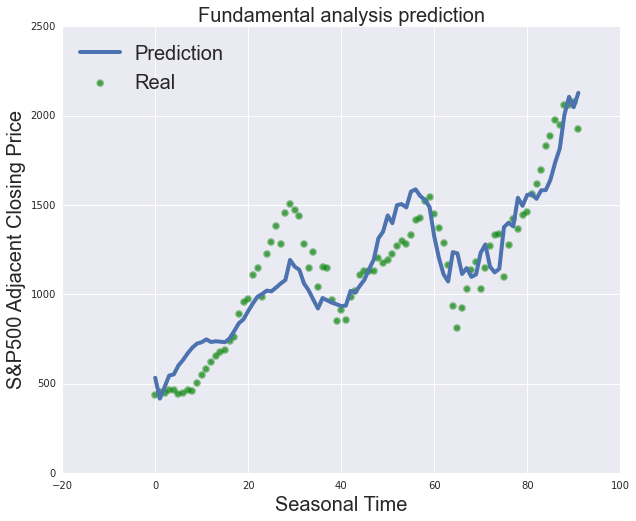

In [929]:
#Set figure size
plt.figure(figsize=(10,8))
plt.title('Fundamental analysis prediction',fontsize=20)
plt.xlabel('Seasonal Time',fontsize=20)
plt.ylabel('S&P500 Adjacent Closing Price',fontsize=20)
#Plot our prediction
plt.plot(epreds,label='Prediction',linewidth=4.0)
#Plot the real data points
plt.scatter(range(len(fund['SP_Adj Close'])),fund['SP_Adj Close'],color='g',label='Real',alpha=0.5,linewidth=3.0)
plt.legend(loc='upper left',fontsize=20)
plt.savefig('fa.png')
plt.show()



In [912]:
len(fund['SP_Adj Close'])

92